Shape dataset (6409, 11)
means:  Close           8.057271e+01
Volume          1.259072e+07
MarketCap       1.279897e+11
Weight          4.173304e-02
Return          6.364129e-04
LogReturn       4.338309e-04
WeightedRet     3.053555e-05
SMA20           8.022321e+01
EMA20           8.021005e+01
RSI14           5.253680e+01
ReturnVola20    1.835859e-02
dtype: float64
stds:  Close           6.781238e+01
Volume          1.708028e+07
MarketCap       1.077200e+11
Weight          1.297622e-02
Return          2.013867e-02
LogReturn       2.012149e-02
WeightedRet     8.541972e-04
SMA20           6.744902e+01
EMA20           6.737596e+01
RSI14           1.213508e+01
ReturnVola20    8.307794e-03
dtype: float64
NaNs per column:


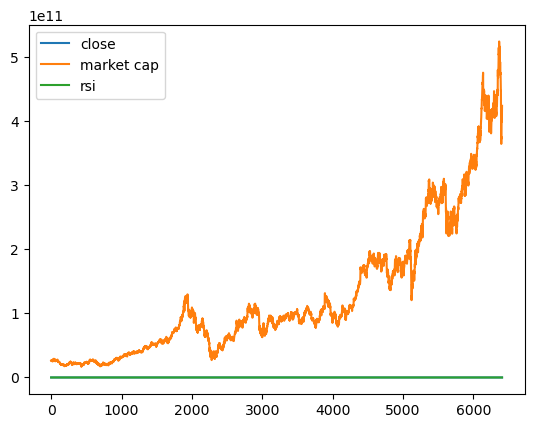

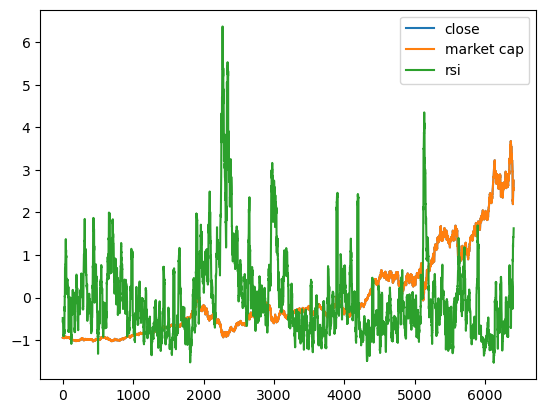

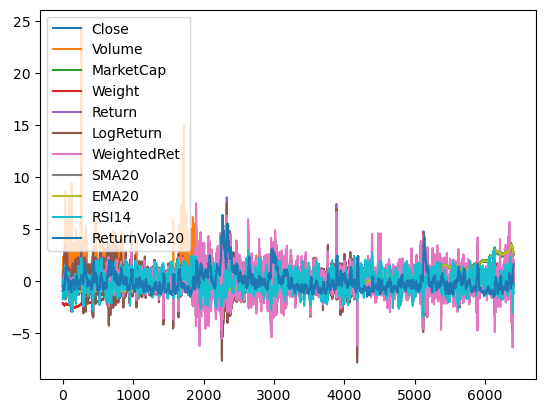

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv(
    "OMXS22_raw_features.csv",
    parse_dates=["Date"],
    index_col="Date"
)

volvo_df = df[df["Ticker"] == "VOLV-B.ST"]
volvo_df = volvo_df.iloc[20:]

volvo_prices = volvo_df["Close"].values    
volvo_market_cap = volvo_df["MarketCap"].values
volvo_rsi = volvo_df["RSI14"].values



feature_cols = ["Close","Volume",
                "MarketCap","Weight",
                "Return","LogReturn","WeightedRet",
                "SMA20","EMA20","RSI14","ReturnVola20"]

volvo_dataset = volvo_df[feature_cols]

print('Shape dataset', volvo_dataset.shape)
#print(volvo_dataset)

volvo_values = volvo_dataset.values

means = volvo_dataset.mean(axis=0)
stds = volvo_dataset.std(axis=0)
print('means: ',means)
print('stds: ', stds)
volvo_dataset_norm = (volvo_dataset - means)/stds 
volvo_values_norm = volvo_dataset_norm.values

norm_close = volvo_values_norm[:,0]
norm_mark_cap = volvo_values_norm[:,2]
norm_rsi = volvo_values_norm[:, 10]

nan_per_col = volvo_dataset.isna().sum()
print("NaNs per column:")

plt.plot(volvo_prices, label= 'close')
plt.plot(volvo_market_cap, label='market cap')
plt.plot(volvo_rsi, label='rsi')
plt.legend()
plt.show()

plt.plot(norm_close, label= 'close')
plt.plot(norm_mark_cap, label='market cap')
plt.plot(norm_rsi, label='rsi')
plt.legend()
plt.show()

for i in range(len(feature_cols)):
    plt.plot(volvo_values_norm[:,i], label= feature_cols[i])

plt.legend()




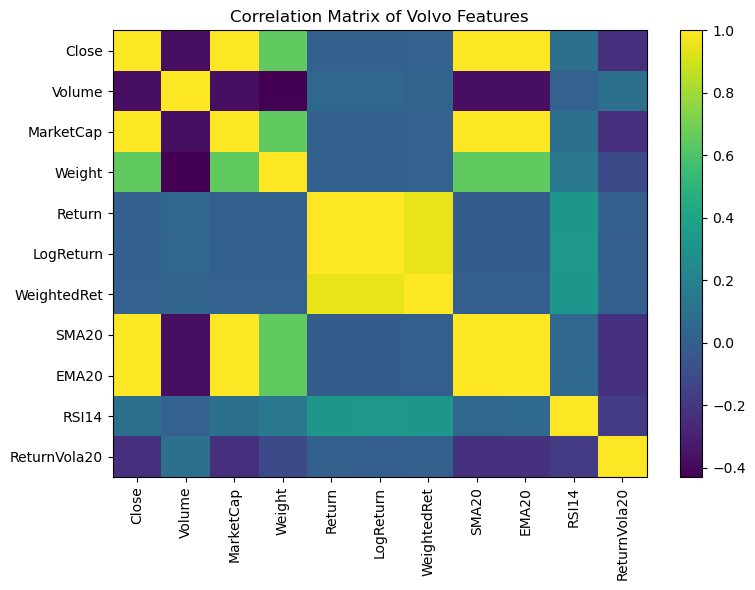

In [119]:
corr = volvo_dataset_norm.corr()
plt.figure(figsize=(8, 6))
im = plt.imshow(corr, aspect='auto')
plt.colorbar(im)
plt.xticks(ticks=np.arange(len(feature_cols)), labels=feature_cols, rotation=90)
plt.yticks(ticks=np.arange(len(feature_cols)), labels=feature_cols)
plt.title("Correlation Matrix of Volvo Features")
plt.tight_layout()
plt.show()


In [273]:
daily_samples = 50
num_test_points = 200
data = volvo_values[:-num_test_points]
test_real_data = volvo_values[-num_test_points:]

n_samples, n_features = data.shape[0], data.shape[1]
past_seq = 2 * daily_samples
lag = 1
temp_idx = 0  # Temperature (Celsius) index

in_sequences, targets = [], []
for i in range(past_seq, n_samples - lag, daily_samples):
    in_sequences.append(data[i - past_seq:i, :])
    targets.append(data[i + lag:i + lag + 1, temp_idx])
in_sequences, targets = np.asarray(in_sequences), np.asarray(targets)
print(targets[10:])

print(in_sequences.shape)
print(targets.shape)

[[ 16.80023003]
 [ 15.45447636]
 [ 11.1133337 ]
 [ 13.4575491 ]
 [ 12.80637455]
 [ 14.85620022]
 [ 17.41604042]
 [ 17.64459801]
 [ 19.70160866]
 [ 21.39292908]
 [ 23.86133957]
 [ 24.63261604]
 [ 24.7741909 ]
 [ 26.33142471]
 [ 25.43483162]
 [ 29.44589233]
 [ 30.82232475]
 [ 33.18193054]
 [ 32.29707718]
 [ 36.72133636]
 [ 34.90248489]
 [ 36.07122421]
 [ 38.79845047]
 [ 46.0538559 ]
 [ 48.5752449 ]
 [ 57.63162994]
 [ 76.53077698]
 [ 65.52109528]
 [ 68.74343109]
 [ 57.06242371]
 [ 48.60375214]
 [ 57.50336838]
 [ 41.84651184]
 [ 27.89767456]
 [ 24.42469978]
 [ 20.32544899]
 [ 31.10949898]
 [ 31.40719795]
 [ 37.36116409]
 [ 36.61692047]
 [ 39.29620743]
 [ 49.269104  ]
 [ 53.34757614]
 [ 54.71698761]
 [ 66.56539154]
 [ 64.3028717 ]
 [ 71.47251892]
 [ 62.82762527]
 [ 39.54122162]
 [ 44.74642181]
 [ 57.3180275 ]
 [ 53.96326828]
 [ 50.15816116]
 [ 57.92560196]
 [ 59.84387589]
 [ 62.48542404]
 [ 60.58998108]
 [ 60.26492691]
 [ 62.57281876]
 [ 54.67401886]
 [ 63.06039047]
 [ 66.80593109]
 [ 57.63

In [274]:
import deeptrack as dt

sources = dt.sources.Source(inputs=in_sequences, targets=targets)
train_sources, val_sources = dt.sources.random_split(sources, [0.8, 0.2])

In [275]:
import torch

train_mean = np.mean([src["inputs"] for src in train_sources], axis=(0, 1))
train_std = np.std([src["inputs"] for src in train_sources], axis=(0, 1))

inputs_pipeline = (dt.Value(sources.inputs - train_mean) / train_std
                   >> dt.pytorch.ToTensor(dtype=torch.float))
targets_pipeline = (dt.Value(sources.targets - train_mean[temp_idx]) 
                    / train_std[temp_idx])

from torch.utils.data import DataLoader

train_dataset = dt.pytorch.Dataset(inputs_pipeline & targets_pipeline,
                                   inputs=train_sources)
val_dataset = dt.pytorch.Dataset(inputs_pipeline & targets_pipeline,
                                 inputs=val_sources)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

for x, y in val_loader:
    print(x)
    print(y)
    break

temperature = data[:, temp_idx]
benchmark_celsius = np.mean(
    np.abs(
        temperature[daily_samples + lag::daily_samples]
        - temperature[lag:-(daily_samples - lag):daily_samples]
    )
)
benchmark = benchmark_celsius / train_std[temp_idx]

print(f"Benchmark Celsius: {benchmark_celsius}")
print(f"Normalized Benchmark: {benchmark}")



tensor([[[-1.0627,  0.6550, -1.0627,  ..., -1.0734,  0.5709,  0.2962],
         [-1.0606,  1.2592, -1.0606,  ..., -1.0724,  0.7117,  0.2950],
         [-1.0543,  1.1004, -1.0543,  ..., -1.0710,  1.0951,  0.2218],
         ...,
         [-1.0454,  0.3152, -1.0454,  ..., -1.0507,  0.0570,  0.2824],
         [-1.0476,  0.3535, -1.0476,  ..., -1.0507, -0.1372, -0.4404],
         [-1.0484,  0.8019, -1.0484,  ..., -1.0507, -0.2029, -0.5221]],

        [[-0.1334, -0.4608, -0.1334,  ..., -0.1570,  0.7626, -0.3847],
         [-0.1264, -0.5237, -0.1264,  ..., -0.1536,  0.8888, -0.3858],
         [-0.1128, -0.3579, -0.1128,  ..., -0.1492,  1.1197, -0.3628],
         ...,
         [-0.0594,  0.8759, -0.0594,  ..., -0.0024, -0.8415,  1.2096],
         [-0.0195, -0.1882, -0.0195,  ..., -0.0035, -0.3780,  1.2437],
         [-0.0243, -0.2922, -0.0243,  ..., -0.0048, -0.4278,  1.2286]],

        [[-0.2548, -0.4405, -0.2548,  ..., -0.2647,  0.1698, -0.2865],
         [-0.2314, -0.4981, -0.2314,  ..., -0

In [276]:
def get_device():
    """Select device where to perform the computations."""
    if torch.cuda.is_available():
        return torch.device("cuda:0")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")
    
device = get_device()
print(device)

cuda:0


In [277]:
def plot_training(epochs, train_losses, val_losses, benchmark):
    """Plot the training and validation losses."""
    plt.plot(range(epochs), train_losses, label="Training Loss")
    plt.plot(range(epochs), val_losses, "--", label="Validation Loss")
    plt.plot([0, epochs - 1], [benchmark, benchmark], ":k", label="Benchmark")
    plt.xlabel("Epoch")
    plt.xlim([0, epochs - 1])
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    

In [278]:
epochs = 200

INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | L1Loss           | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | RecurrentModel   | 17.0 K | train
5 | optimizer     | Adam             | 0      | train
-----------------------------------------------------------
17.0 K    Trainable params
0         Non-trainable params
17.0 K    Total params
0.068     Total estimated model params size (MB)
23        Modules in train mode
1         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | L1Loss           | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollec

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

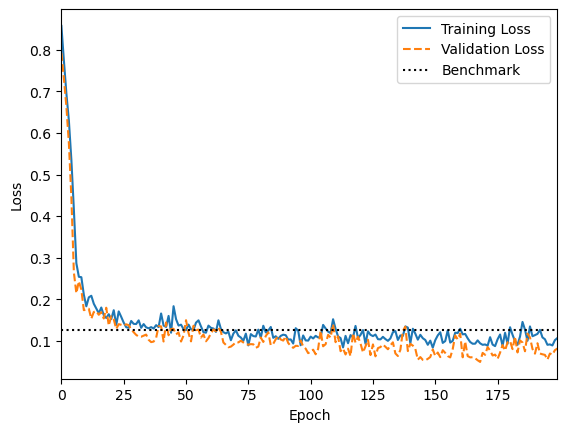

In [279]:
import deeplay as dl

gru_dl = dl.RecurrentModel(
    in_features=n_features,
    hidden_features=[32, 32, 32],
    out_features=1,
    rnn_type="GRU",
    dropout=0.2,
)
gru_stacked = dl.Regressor(gru_dl, optimizer=dl.Adam(lr=0.001)).create()

trainer = dl.Trainer(max_epochs=epochs, accelerator="auto")
trainer.fit(gru_stacked, train_loader, val_loader)

train_losses = trainer.history.history["train_loss_epoch"]["value"]
val_losses = trainer.history.history["val_loss_epoch"]["value"][1:]
plot_training(epochs, train_losses, val_losses, benchmark)

In [284]:
gru_stacked.eval()
with torch.no_grad():
    for i, batch in enumerate(val_loader):
        x_batch, y_batch = batch
        #print(y_batch)
        test_prediction = gru_stacked(x_batch)
        
        break

print("Last 10 timesteps (input) and true vs predicted temperature:")
for i in range(20):
    
    last_input_temp = x_batch[i, -1, 1].item()  
    true_temp = y_batch[i].item()
    predicted_temp = test_prediction[i].item()

    print(f"Sample {i+1}: Last input temp = {last_input_temp:.2f}, True = {true_temp:.2f}, Pred = {predicted_temp:.2f}")

Last 10 timesteps (input) and true vs predicted temperature:
Sample 1: Last input temp = 0.80, True = -1.04, Pred = -1.07
Sample 2: Last input temp = -0.29, True = -0.04, Pred = 0.06
Sample 3: Last input temp = -0.15, True = -0.20, Pred = -0.16
Sample 4: Last input temp = -0.52, True = 0.62, Pred = 0.76
Sample 5: Last input temp = -0.36, True = 1.10, Pred = 1.27
Sample 6: Last input temp = -0.06, True = -0.94, Pred = -0.78
Sample 7: Last input temp = -0.43, True = -1.03, Pred = -1.03
Sample 8: Last input temp = -0.16, True = -0.29, Pred = -0.26
Sample 9: Last input temp = -0.60, True = 0.71, Pred = 0.81
Sample 10: Last input temp = 0.03, True = -0.88, Pred = -0.91
Sample 11: Last input temp = -0.04, True = -0.51, Pred = -0.48
Sample 12: Last input temp = -0.67, True = -0.99, Pred = -0.99
Sample 13: Last input temp = -0.28, True = 0.01, Pred = 0.07
Sample 14: Last input temp = -0.50, True = -0.30, Pred = -0.31
Sample 15: Last input temp = -0.50, True = 1.97, Pred = 2.07
Sample 16: Last 

In [285]:
gru_stacked.eval()

train_mean_torch = torch.tensor(train_mean, dtype=torch.float32)
train_std_torch = torch.tensor(train_std, dtype=torch.float32)
print(train_mean_torch)
print(train_std_torch)

last_window = torch.tensor(data[-daily_samples*2:], dtype=torch.float32)
last_window = (last_window - train_mean_torch ) / train_std_torch
print(last_window.shape)
print(last_window)


test_real_data_torch = torch.tensor(test_real_data, dtype=torch.float32)
test_real_data_torch = (test_real_data_torch - train_mean_torch)/ train_std_torch
print('test data shape', test_real_data_torch.shape)

print(test_real_data_torch)

preds_norm = []
true_norm = []

with torch.no_grad():
    for t in range(num_test_points):
        x_in  = last_window.unsqueeze(0)
        pred_torch = gru_stacked(x_in)
        print(pred_torch)
        pred_norm = pred_torch.squeeze().item()

        preds_norm.append(pred_norm)
        true_norm.append(test_real_data_torch[t, 0])

        true_indicators = test_real_data_torch[t, :]
        true_indicators[0] = pred_norm

        next_data_point = torch.tensor(true_indicators, dtype=torch.float32)
        last_window = torch.cat([last_window[1:], next_data_point.unsqueeze(0)], dim=0)


tensor([7.3769e+01, 1.2929e+07, 1.1718e+11, 4.1159e-02, 6.3529e-04, 4.5235e-04,
        3.1701e-05, 7.3400e+01, 7.3403e+01, 5.2624e+01, 1.7661e-02])
tensor([5.6959e+01, 1.7247e+07, 9.0479e+10, 1.2424e-02, 1.9119e-02, 1.9126e-02,
        8.0422e-04, 5.6474e+01, 5.6447e+01, 1.2166e+01, 7.3820e-03])
torch.Size([100, 11])
tensor([[ 3.0984, -0.6107,  3.0984,  ...,  2.9788,  1.3511, -0.9702],
        [ 3.1546, -0.5736,  3.1546,  ...,  2.9988,  1.6266, -0.9453],
        [ 3.1669, -0.5689,  3.1669,  ...,  3.0182,  1.6835, -0.9952],
        ...,
        [ 3.2155, -0.5889,  3.2155,  ...,  3.3118, -0.8346, -0.8410],
        [ 3.1597, -0.6416,  3.1597,  ...,  3.3006, -1.1485, -0.8278],
        [ 3.2138, -0.6424,  3.2138,  ...,  3.2958, -0.7156, -0.7772]])
test data shape torch.Size([200, 11])
tensor([[-1.2502, -0.6107,  3.2680,  ...,  3.2966, -0.3254, -0.7702],
        [-1.2519, -0.5908,  3.3746,  ...,  3.3075,  0.3166, -0.7318],
        [-1.2539, -0.6332,  3.3289,  ...,  3.3130,  0.0120, -0.8197]

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_929000\2916365674.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_data_point = torch.tensor(true_indicators, dtype=torch.float32)


tensor([[2.8702]])
tensor([[2.8685]])
tensor([[2.8681]])
tensor([[2.8705]])
tensor([[2.8702]])
tensor([[2.8661]])
tensor([[2.8577]])
tensor([[2.8472]])
tensor([[2.8355]])
tensor([[2.8270]])
tensor([[2.8151]])
tensor([[2.8056]])
tensor([[2.8012]])
tensor([[2.8038]])
tensor([[2.8040]])
tensor([[2.8128]])
tensor([[2.8225]])
tensor([[2.8341]])
tensor([[2.8404]])
tensor([[2.8428]])
tensor([[2.8477]])
tensor([[2.8492]])
tensor([[2.8572]])
tensor([[2.8646]])
tensor([[2.8670]])
tensor([[2.8653]])
tensor([[2.8620]])
tensor([[2.8557]])
tensor([[2.8604]])
tensor([[2.8672]])
tensor([[2.8714]])
tensor([[2.8745]])
tensor([[2.8754]])
tensor([[2.8743]])
tensor([[2.8749]])
tensor([[2.8743]])
tensor([[2.8741]])
tensor([[2.8666]])
tensor([[2.8718]])
tensor([[2.8792]])
tensor([[2.8836]])
tensor([[2.8872]])
tensor([[2.8834]])
tensor([[2.8877]])
tensor([[2.8968]])
tensor([[2.9054]])
tensor([[2.9106]])
tensor([[2.9126]])
tensor([[2.9120]])
tensor([[2.9098]])
tensor([[2.9123]])
tensor([[2.9032]])
tensor([[2.9

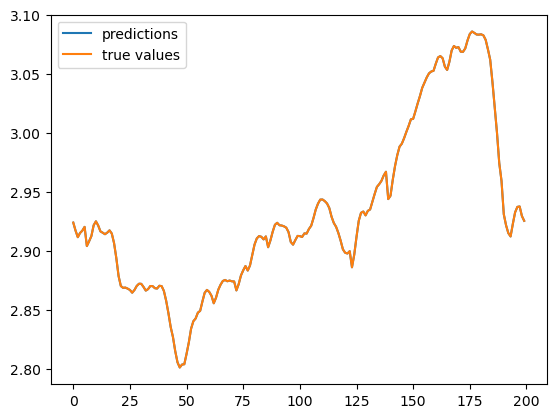

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


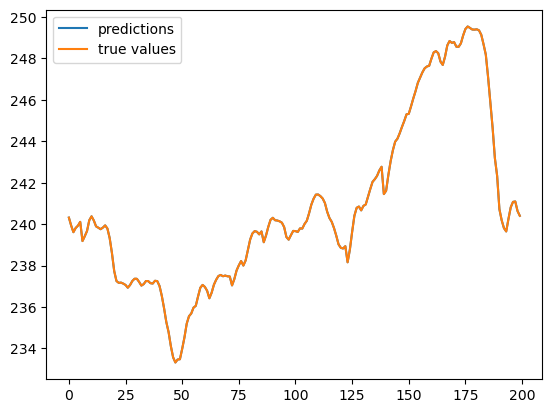

In [286]:
plt.plot(preds_norm, label='predictions')
plt.plot(true_norm, label='true values')
plt.legend()
plt.show()

real_val_pred = np.array(preds_norm) * train_std[temp_idx] + train_mean[temp_idx]
real_val_true = np.array(true_norm) * train_std[temp_idx] + train_mean[temp_idx]

print(real_val_pred - real_val_true)

plt.plot(real_val_pred, label='predictions')
plt.plot(real_val_true, label='true values')
plt.legend()



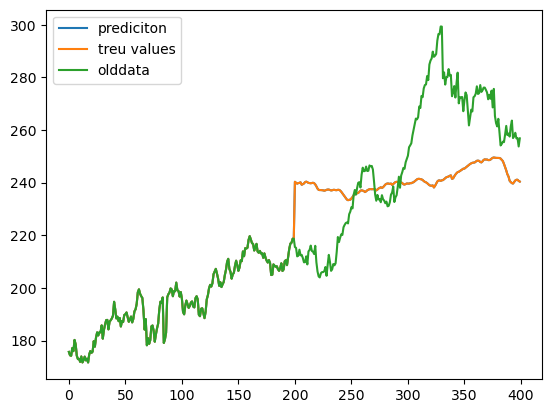

In [283]:
old_data = data[-400:-200]
real_old_data = np.array(old_data[:,0])

real_long_pred = np.concat([real_old_data, real_val_pred])
real_long_true = np.concat([real_old_data, real_val_true])

plt.plot(real_long_pred, label='prediciton')
plt.plot(real_long_true, label='treu values')
plt.plot(data[-400:][:,0], label='olddata')
plt.legend()